In [1]:
#Importing the necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.preprocessing import FunctionTransformer,OneHotEncoder,LabelEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn import svm
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.stats import randint
from sklearn.linear_model import LogisticRegression
#from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score, recall_score, precision_score, roc_auc_score,roc_curve
import datetime
from scipy.stats import pearsonr
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import warnings
#from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
#from plotnine import *
from Functions.BAMP import *
from Functions.prediction import *
from sklearn.metrics import balanced_accuracy_score,cohen_kappa_score
warnings.filterwarnings("ignore")
import scipy
#import shap

#shap.initjs()

The variables below are for initializing the classifier, in this case is an XGBOOST Algorithm

In [2]:
#CREATES A MODEL
MODEL = XGBClassifier()


## Instructions and General comments

The code for our BAMP project was created with the idea that all functions will be utilize in production as such, most of the time we will be calling automated functions to perform the tasks, this type of object oriented architecture allow us to automate our project and eventually be able to deploy the project in Biotest centers.

In [3]:
#GLOBAL VARIABLES


TRAINNING_DATA = 'Data/training_2022-08-01.csv' # DEFINES THE PERIOD IN THIS CASE THE DATA FOR TRAINING/TESTING IS ONE YEAR FROM THE PERIOD OF JANUARY 2020 TO JANUARY 2021 
VAR_CLUSTERING =  ['fc.Risk.Def', 'fc.Churn.Def','Last.Visit.gap','Donation.Period'] # WE TESTED CLUSTERING AS AN ADDITIONAL FEATURE, BUT IT DIDN'T BRING ANY RESULTS, IN THE END WE CAN LEAVE IT AS SOMETHING TO EXPLORE IN PRODUCTION
PREDICTING_VAR = ['target'] # THE PREDICTING VARIABLE IN THIS CASE IF A DONOR CHURN OR NOT DURING THE PERIOD OF FEBRUARY 2021 to AUGUST 2021
# THE VARIABLES BELOW ARE IN TABLE 10 SECTION 3.4 IN THE MASTER
FINAL_VAR = ['Avg.Weight', 'Gender', 'Age','Sum.Total.Payment', 'Avg.Payment','Total.Protein', 'fc.Risk.Def','fc.Churn.Def', 'Donation.Period', 'Number.Appointments',
       'Normalized.Frequency', 'First.Visit.gap',
       'Last.Visit.gap', 'Mean.Apointment.Gap', 'Norm.gap',
       'New.Donor','Location.Key'] 



# EVALUATION 1 

This notebook corresponds to the following period:

- Training & Testing Data set: Donation data for individual donnors for the period of  01/08/2019 to 01/08/2020 - Including the Target Variables
- The data set is aggregated using the R code (Data Aggregation), that code exports the data in to a csv file that we are using in this notebook

### Loading and Transforming Data

The function ETL_PIPELINE is define in the file BAMP.py inside the function folder, The code implements an ETL (Extract, Transform, Load) pipeline for processing donor data. The code performs the following steps:

- Imports the donor data from the specified directory.
- Replaces any infinite values in the data with 0.
- Creates a new variable "New_Donation_Adjusted" based on the values of the existing variables "Last.Visit.gap" and "New.Donor".
- Scales the specified clustering variables.
- Uses the KMeans algorithm to perform clustering and determines the number of clusters based on the silhouette coefficient.
- Adds a new variable "Clustering" to the donors data, representing the cluster assignment for each donor.

For this thesis it was decided not to to use New_Donation_Adjusting and Clustering features as they were not improving the results, please note that the variables will be created but since this are not included in FINAL_VAR global vairble, the variables won't be utilized

In [4]:
donors = ETL_pipeline(TRAINNING_DATA,VAR_CLUSTERING)
# ETL_PIPELINE FUNCTION IS 

The file you are loading is a:Data/training_2022-08-01.csv, with :12966 observations, and 24,variable


: 

: 

It is worth highlighting that the variable donors is a dataframe that contains all variables (including 2 newly created variables)

## Data Analysis

The function bar_churn, plots the target variable classes (1 or 0), it is obvious that there is an imbalanced in the dataset

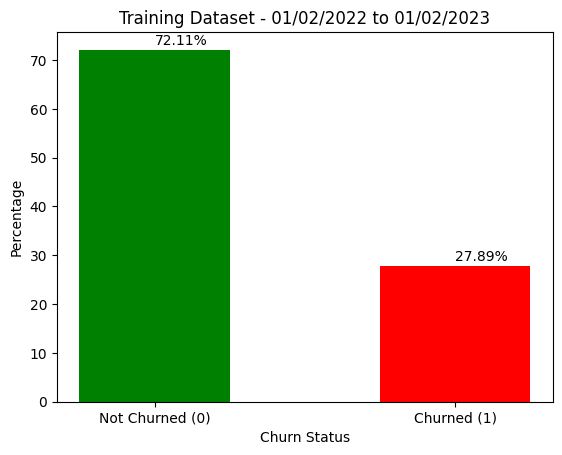

In [20]:
bar_churn(donors,"target","Training Dataset - 01/02/2022 to 01/02/2023")

Let's explore correlation in the dataset

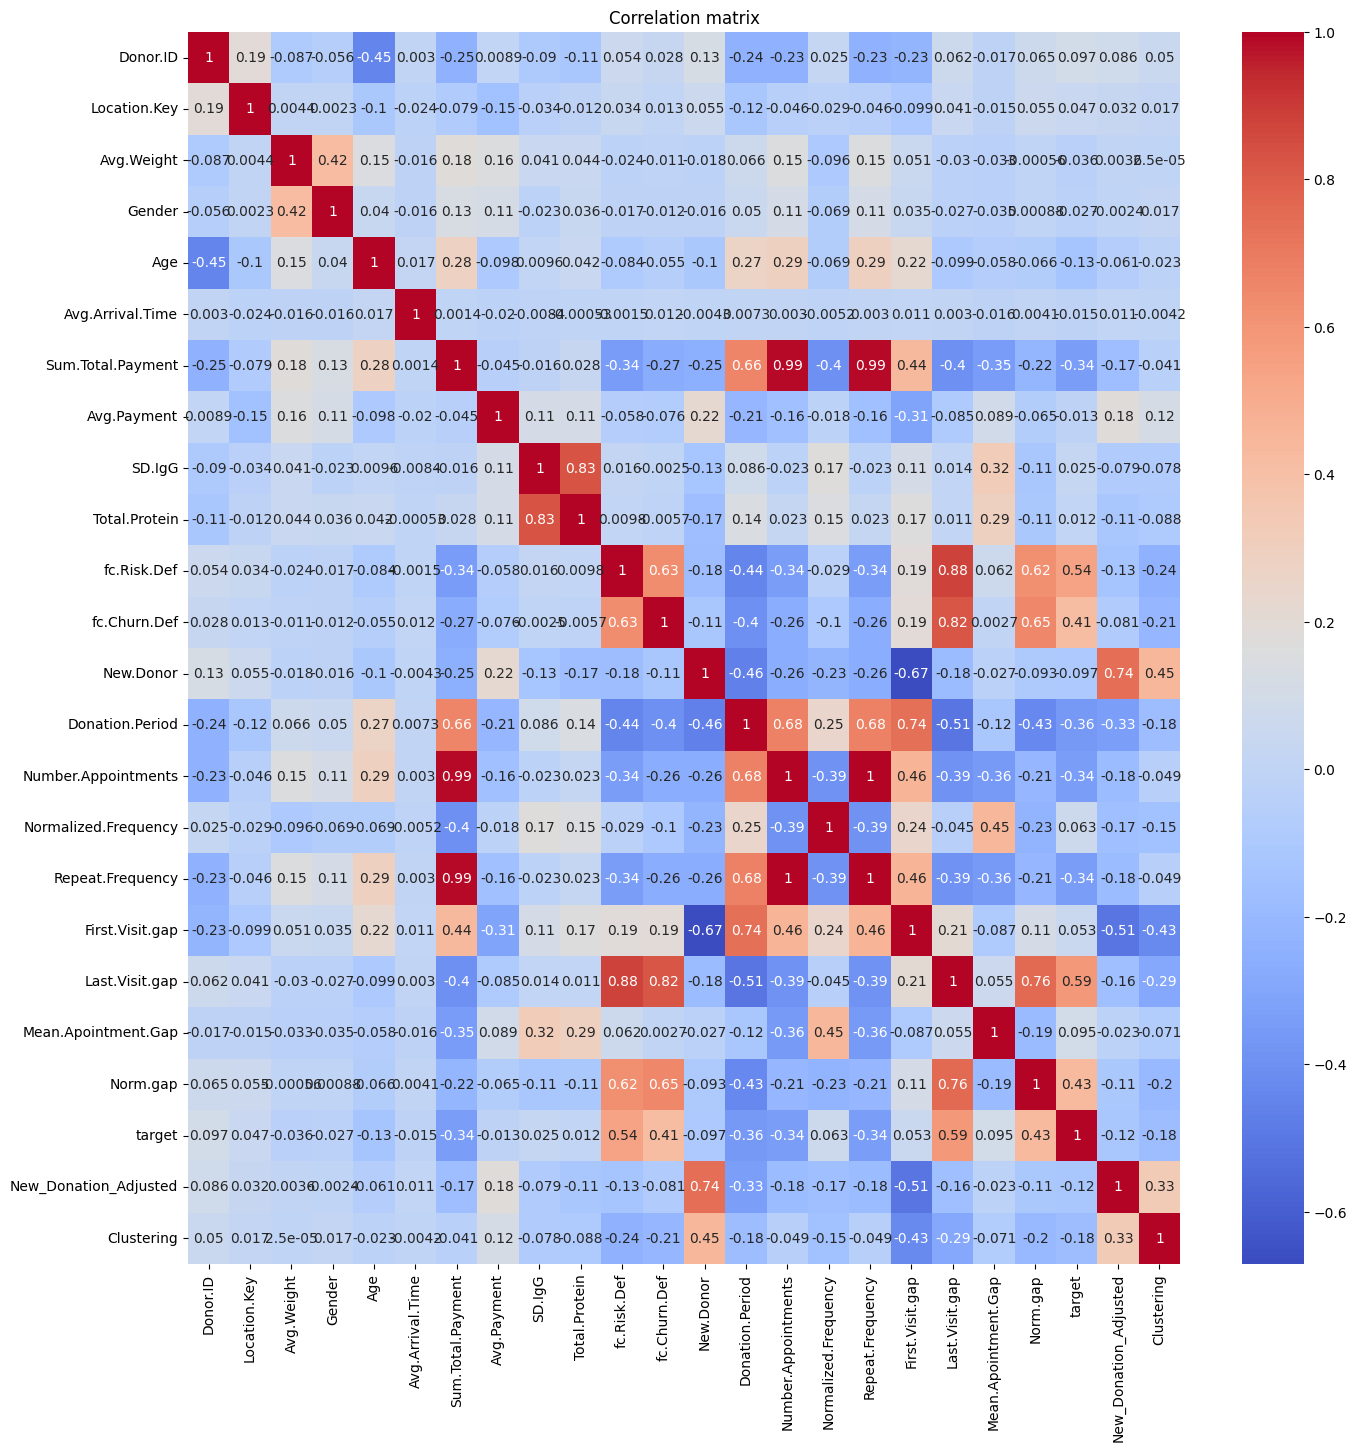

In [21]:

# Calculate the correlation matrix on all variables
corr = donors.corr()

# Create a mask to only display the correlation values above a certain threshold
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap of the correlation matrix
fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax)

# Set the title and show the plot
plt.title('Correlation matrix')
plt.show()

We can see that the target variable is correlated to FC.RISK DeF (0.55), FC.churn Def(0.41), Last.Visit.Gap(0.59) and Norm.Gap (0.43) whcih is part of the 10 variables selected

The code below checks missing values in the dataset

In [22]:
missing_values_table(donors)

Your selected dataframe has 26 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
Avg.Arrival.Time,2,0.0


The feature Avg. Arrival.Time is not included in our FINAL_VAR

The function below simply receives the number of positive values, it is useful to know the % of (1) churn cases, as we will need that value to balanced our dataset when we are training our XGBoost classifier

In [23]:
pos = pos_neg_target(donors) * 2


Examples:
    Total: 12966
    Positive: 3616 (27.89% of total)



## Data Visualization

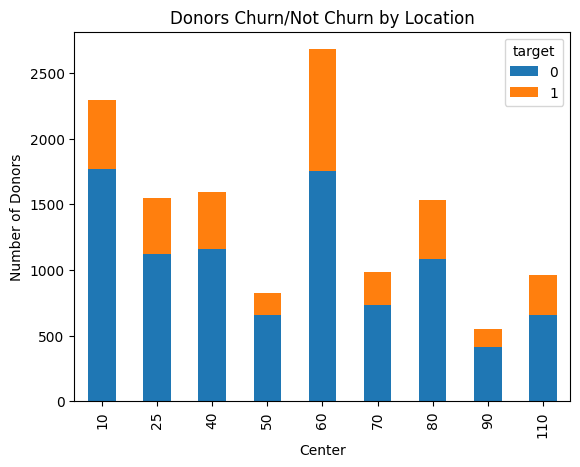

In [24]:
# group the data by Location.Key and Results, and count the number of occurrences
grouped_data = donors.groupby(['Location.Key', 'target']).size().reset_index(name='Count')

# create a pivot table to reshape the data for plotting
pivot_data = pd.pivot_table(grouped_data, values='Count', index='Location.Key', columns='target')

# plot the data as a stacked bar chart
pivot_data.plot(kind='bar', stacked=True)

# add axis labels and title
plt.xlabel('Center')
plt.ylabel('Number of Donors')
plt.title('Donors Churn/Not Churn by Location')

# show the plot
plt.show()

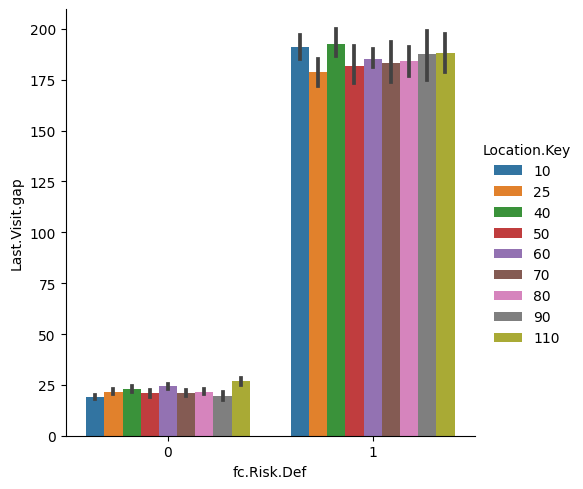

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
# Create a scatter plot using seaborn
# Create a grouped bar plot using seaborn
sns.catplot(data=donors, x="fc.Risk.Def", y="Last.Visit.gap", hue="Location.Key", kind="bar")

# Show the plot
plt.show()

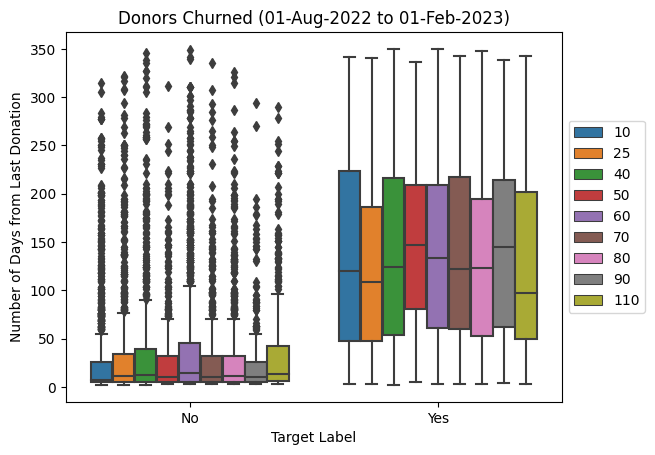

In [37]:

# Replace 1 with "No" and 0 with "Yes" in the "fc.Risk.Def" column
donors["target"].replace({1: "Churned", 0: "Not Churned"}, inplace=True)
# Create a violin plot using seaborn
sns.boxplot(data=donors, x="target", y="Last.Visit.gap", hue="Location.Key")

# Set the title and axis labels
plt.title("Donors Churned (01-Aug-2022 to 01-Feb-2023)")
plt.xlabel("Target Label")
plt.ylabel("Number of Days from Last Donation")

# Move the legend outside the plot area
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Show the plot
plt.show()

### Splitting Training and Test Dataset

The datasets function is in the functions folder BAMP.py and creates the split for training and test dataset

In [9]:
x_train,x_test,y_train,y_test = datasets(donors,0.2,FINAL_VAR,PREDICTING_VAR)

pipeline churn function is located in the functions folder BAMP.py  and it simpply scales the features, this is part of section 3.3.3 (data normalization) in our master thesis

In [10]:
X_train_prepared,X_test_prepared = pipeline_churn(x_train,x_test)
print(X_train_prepared.shape,X_test_prepared.shape)

(10372, 16) (2594, 16)


### Machine Learning Portion

The "random_search" function takes in four arguments:

1.- A machine learning model (model)
2.- Training features (X)
3.- Training target (y)
4.- A dictionary of hyperparameters to be used for random search (params)

- The function applies StratifiedKFold cross-validation with 20 splits, shuffled, and with a random state of 42.
- The randomized search is performed using the input model, hyperparameters (params), and the cross-validation setup defined by kfold.
- The number of iterations for the random search is 20, and the number of jobs (-1) is set to use all available cores.
- The scoring metric used for evaluation is recall.

The fit method is then applied to the random search object with the training features and target, updating the random search object with the results of the fitting process.
The best score obtained from the random search is then printed.

Finally, the function returns the best set of hyperparameters found by the random search, this hyperparameters will be calculated each time the model is trained as per page 52 of the master thesis, meaning that this function will be run every time, and the best parameters are calculated for each training dataset

##### Hyper Parameters

As per section 3.4.2 Interpretability, since we know that our Xgboost algorithm performs well, we can simply provide a set of hyperparamaters to improve 

In [13]:
#XGBOOST PARAMETERS FOR HYPERPARAMETER TUNING

params = {'subsample':[0.65,0.7,0.8,1],
          'learning_rate':[0.001,0.1,0.005,0.2],
          'n_estimators': [200,400, 600, 1000],
          'colsample_bytree':[0.5,0.7,0.8,0.9],
          'random_state':[42],
          'booster':['gbtree'],
          'max_depth':[2,4,6,8,10],
          'eta':[0.1,0.2,0.3,0.5],
          'gamma':[0.05,0.1,0.5,1],
          'reg_alpha': [0,0.1,0.5,0.8,1],
          #'reg_lambda': [0,0.1,0.5,0.8,1],
          'scale_pos_weight':[],
          #'early_stopping_rounds':[20],          
            
            }
# ADDS the Scale_pos_Weight as explained in page 55 of the thesis
params["scale_pos_weight"] = [pos]


The function belows stores the best hyper parameters in a variable

In [ ]:
#model_best_params = random_search(MODEL,X_train_prepared,y_train,params)

The best score is: 0.9117090671885192


In [ ]:
'''
{'subsample': 1,
 'scale_pos_weight': 5.17146017699115,
 'reg_alpha': 0.8,
 'random_state': 42,
 'n_estimators': 200,
 'max_depth': 4,
 'learning_rate': 0.001,
 'gamma': 0.05,
 'eta': 0.3,
 'colsample_bytree': 0.8,
 'booster': 'gbtree'}
'''

In [14]:

model_best_params = {'subsample': 1,
 'scale_pos_weight': 5.17146017699115,
 'reg_alpha': 0.1,
 'random_state': 42,
 'n_estimators': 200,
 'max_depth': 2,
 'learning_rate': 0.005,
 'gamma': 0.5,
 'eta': 0.1,
 'colsample_bytree': 0.5,
 'booster': 'gbtree'}

 

The model above was run in the training dataset

### Predicting on the Test Dataset

In [15]:
#If you change the ML algorithm, you have to provide the name without parenthesis, I can probably automate this, but it is a pythonic 
#issue in whereby if you pass a variable to function, you are essentially passing a character not an object
y_pred,cf,model = run_final_model(XGBClassifier,model_best_params,X_train_prepared,X_test_prepared,y_train,y_test)

Generalization Score:  0.71
              precision    recall  f1-score   support

           0       0.95      0.64      0.77      1900
           1       0.48      0.90      0.63       694

    accuracy                           0.71      2594
   macro avg       0.71      0.77      0.70      2594
weighted avg       0.82      0.71      0.73      2594



In [16]:
##Balanced Accuracy

balanced_accuracy_score(y_test,y_pred)

0.7735021993022904

As explained in the thesis, the churn donation problem relies in maximize the predicting power of the algorithm for the positive class (1 - churn). As such, for the positive class the recall is high and the accuracy of the model is 76% which is acceptable for this type of problems, whilst we were able to improve the accuracy of the model by using other methods, as explain in the master thesis, from a business perspective the objective is to maximize the True Positives 

### Confusion Matrix

<Axes: >

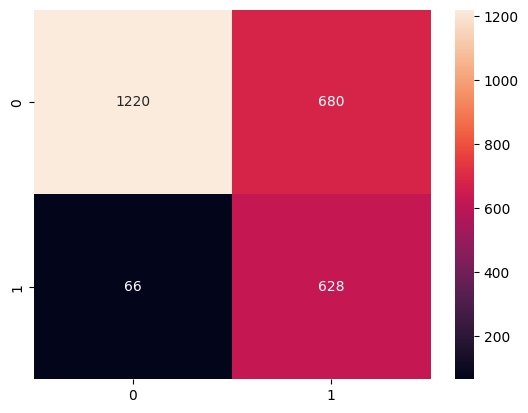

In [17]:
### Confusion Matrix
sns.heatmap(cf, annot=True,fmt='d')

The confusion matrix shows a very good response to predictiing the positive class

In [18]:
## Extracting Probabilities
predicted_prob = model.predict_proba(X_test_prepared)

### Plotting ROC Curve

ROC (Receivr Operator Characteristics) curve helps to understand which is the best threshold to use

The plot is composed of the following:
* x-axis: True Positive Rate (Sensitivity) on y-axis (Proportion of poor care caught)
* y-axis: False Positive Rate (1-specificity) - Proportion of goog care labeles as poor care

In [22]:
## Plotting AOC_Curve
from sklearn import metrics
metrics.roc_curve(model,X_test_prepared,y_test)

TypeError: roc_curve() takes 2 positional arguments but 3 were given

In [20]:
plot_roc_curve(model,X_train_prepared,y_train)

NameError: name 'plot_roc_curve' is not defined

Overall Very good response from the False Positve Rate

In [23]:
## Explanatory Plots 
#Probability of Churn
distrib = pd.DataFrame({
    "probability":predicted_prob[:,1],
    "result":y_test["target"]
})


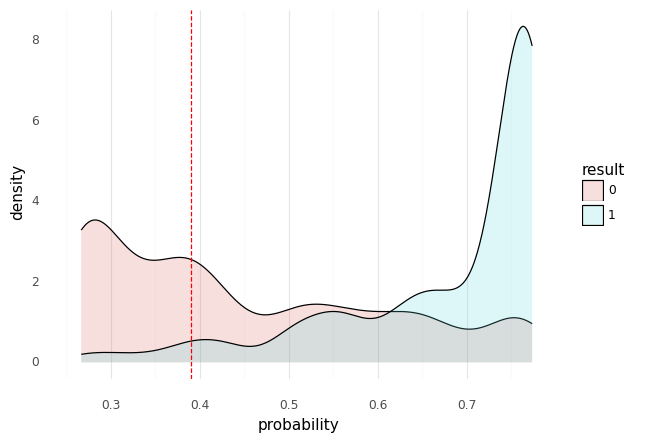

<ggplot: (8761784747942)>

In [25]:

from plotnine import *

thresh = 0.39
(ggplot(distrib, aes(x = "probability",  fill = "factor(result)")) + geom_density(alpha = 0.2) +
 theme_minimal() +
 scale_fill_discrete(name = "result") +
 theme(panel_grid_major_y = element_blank(),
       panel_grid_minor_y = element_blank()) +
 geom_vline(xintercept = thresh, color = "red", linetype = "dashed"))


Text(0.5, 1.0, 'Training Dataset')

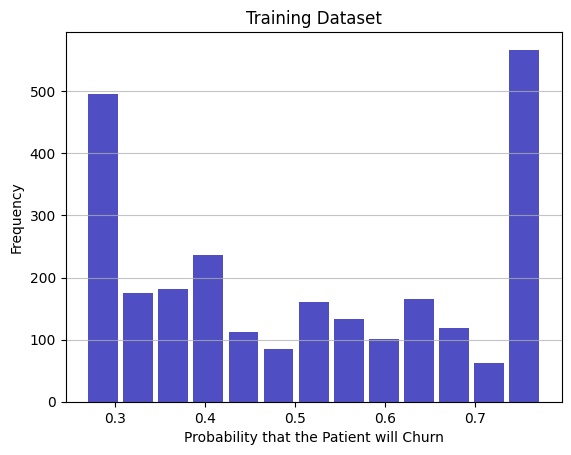

In [26]:
plt.hist(x=distrib["probability"], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Probability that the Patient will Churn')
plt.ylabel('Frequency')
plt.title('Training Dataset')

The 2 graphs above shows that the classifier is capable of classifying the Positive class with more than 60% probability

## Feature Importance

Text(0, 0.5, 'Feature')

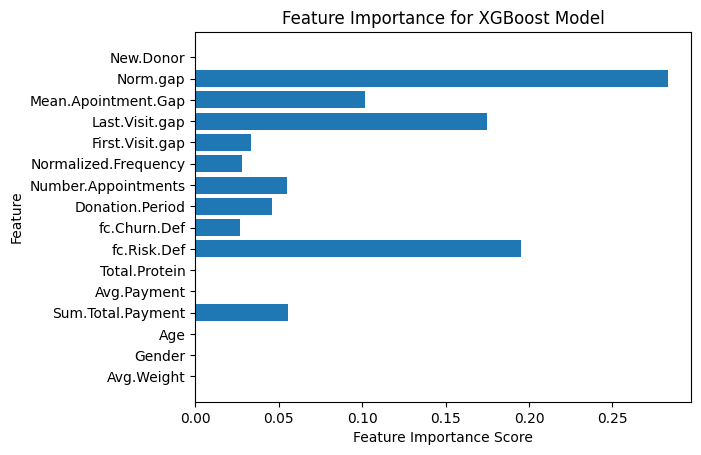

In [27]:
##GENERATE FUNCTION FOR FEATURE IMPORTANCE (ONLY WORKS FOR XGBOOST)
plt.barh(FINAL_VAR, model.feature_importances_)
# Adding titles
plt.title("Feature Importance for XGBoost Model")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")


### Pilot Test

We are going to input the evaluation dataset, which consists in one year of donation aggregated data that will be use to predict the next 6 months as described in the thesis


In [28]:

# The first evaluation period

production_file_name = 'Data/production_2023-02-01.csv'

def prod_pipeline(file,model,var):
    data = pd.read_csv(file)
    x_val = pipeline_churn_val(data[var])
    y_pred = model.predict(x_val)
    results = pd.DataFrame({
                            "Donor.ID":data['Donor.ID'],
                            "Location.Key":data['Location.Key'],
                            "Number.Appointments":data["Number.Appointments"],
                            "Last.Visit.Gap":data["Last.Visit.gap"],
                            "Results":y_pred
                            })
    return results



In [29]:
results = prod_pipeline(production_file_name,model,FINAL_VAR)

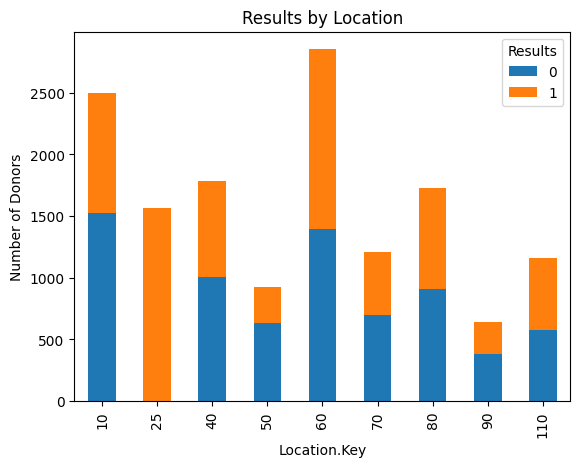

In [30]:
# group the data by Location.Key and Results, and count the number of occurrences
grouped_data = results.groupby(['Location.Key', 'Results']).size().reset_index(name='Count')

# create a pivot table to reshape the data for plotting
pivot_data = pd.pivot_table(grouped_data, values='Count', index='Location.Key', columns='Results')

# plot the data as a stacked bar chart
pivot_data.plot(kind='bar', stacked=True)

# add axis labels and title
plt.xlabel('Location.Key')
plt.ylabel('Number of Donors')
plt.title('Results by Location')

# show the plot
plt.show()

In [31]:
testdata_prediction_dict = predictions_dictionary(test_data_dict,FINAL_VAR,model,0.5)

NameError: name 'test_data_dict' is not defined

Bad pipe message: %s [b'\xcau\xc3\xd2\xe1fI\x9fq\x8a\x0e\xd90\x8ea\xc2h\x1a \x1e\xbc\xb9\xa8\xadL\xbc\xc7\xd4\xfd\x8d\x15(\xca0\xfc\xb39\xc1\x88|(\xf7\x91\xeec}f\x11\xf4f)\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00']
Bad pipe message: %s [b'\xc5\x1a\x1c\x11Gq0\x8fU\x17\xaciZy\x05\x16\x9b\\ \x06%^Qt\x93]uZ\x99\xa4{F\xe4\xfe=H\x97\xa7\xdd\x85\x8d\x1a\xa4\xd8<PT\xc6l\xaf\x1e\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\

########################
Report for the Period: 2021-02-01
                         
                 precision    recall  f1-score   support

Not Churned (0)       0.97      0.61      0.75      7387
    Churned (1)       0.39      0.94      0.55      1940

       accuracy                           0.68      9327
      macro avg       0.68      0.77      0.65      9327
   weighted avg       0.85      0.68      0.71      9327

########################
########################
Balanced Accuracy:
0.7719405014939871
########################
Kappa Score:
0.35595556272661266


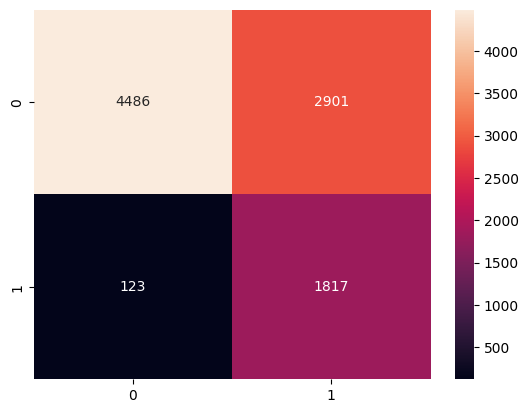

In [ ]:
for key,value in testdata_prediction_dict.items():
    print("########################")
    print(f"Report for the Period: {key}")
    print("                         ")
    print(testdata_prediction_dict[key]['report'])
    print("########################")
    sns.heatmap(testdata_prediction_dict[key]['cm_val'], annot=True,fmt='d')
    print("########################")
    print("Balanced Accuracy:")
    print(balanced_accuracy_score(test_data_dict[key]["target"], testdata_prediction_dict[key]['y_val']))
    print("########################")
    print("Kappa Score:")
    print(cohen_kappa_score(test_data_dict[key]["target"], testdata_prediction_dict[key]['y_val']))


    
   

Overall very high Recall (True-Positive)

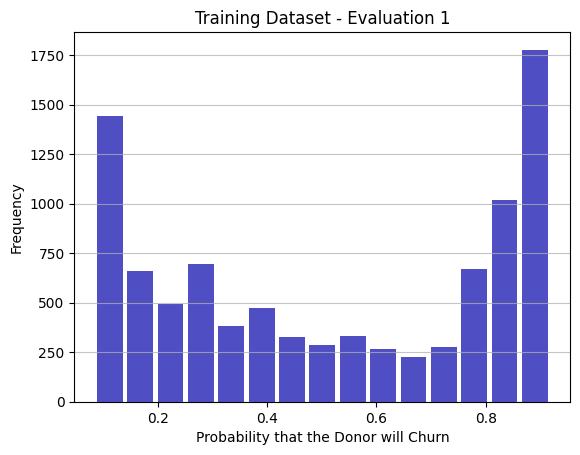

In [ ]:
for key,value in testdata_prediction_dict.items():
    plt.hist(x=testdata_prediction_dict[key]['predicted_prob'][:,1], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Probability that the Donor will Churn')
    plt.ylabel('Frequency')
    plt.title('Training Dataset - Evaluation 1')   

In [ ]:
## Explanatory Plots 
#Probability of Churn
distrib = pd.DataFrame({
    "probability":testdata_prediction_dict['2021-02-01']['predicted_prob'][:,1],
    "result":test_data_dict['2021-02-01']["target"]
})

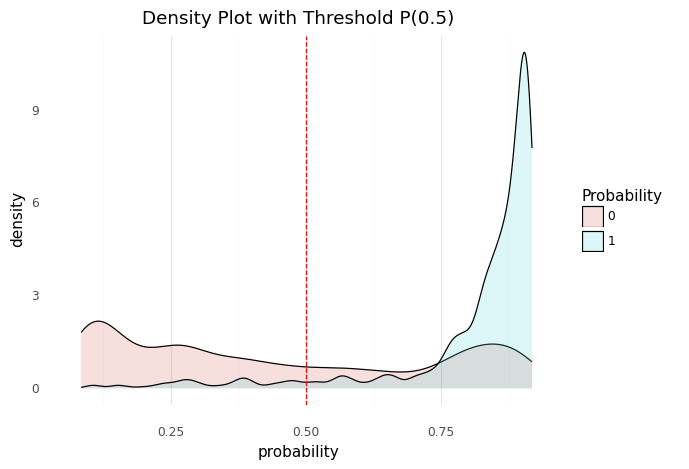

<ggplot: (8745699088967)>

In [ ]:
thresh = 0.5
(ggplot(distrib, aes(x = "probability",  fill = "factor(result)")) + geom_density(alpha = 0.2) +
 theme_minimal() +
 scale_fill_discrete(name = "Probability") +
 theme(panel_grid_major_y = element_blank(),
       panel_grid_minor_y = element_blank()) +
 geom_vline(xintercept = thresh, color = "red", linetype = "dashed")+
 ggtitle("Density Plot with Threshold P(0.5)"))

## Model Interpretability - SHAP Values

In [32]:

df_shap = pd.DataFrame(testdata_prediction_dict["2021-02-01"]["x_val"], columns=FINAL_VAR)

NameError: name 'testdata_prediction_dict' is not defined

In [ ]:
# compute the SHAP values for every prediction in the validation dataset
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_shap)

**Force plots** provide a visual representation of the feature contributions towards a specific prediction made by the model. It is an effective tool for explaining the decision-making process of the model for a particular instance. This makes it easier to understand and communicate the predictions made by the model to others.

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0,:],df_shap.loc[0,:])

In the plot above, the bold -0.13 is the model’s score for this observation. Higher scores lead the model to predict 1 and lower scores lead the model to predict 0. The features that were important to making the prediction for this observation are shown in red and blue, with red representing features that pushed the model score higher, and blue representing features that pushed the score lower. Features that had more of an impact on the score are located closer to the dividing boundary between red and blue, and the size of that impact is represented by the size of the bar.

It is worth noting that this is analyzing one donnor, so each donors will have it's own force plot, this is a great tool to assess the predictions of the algorithms before making the financial contribution

#### Summary Plot

We utilize the visualization capabilities of the SHAP library to examine the contribution of 
individual features towards the prediction of the classifier, as evidenced in the resulting plot 
(see figure 25). The information presented can be succinctly stated as follows. A positive SHAP 
value signifies a positive contribution of the feature towards the prediction of customer churn. 
Conversely, a negative SHAP value represents a negative contribution of the feature towards 
the prediction of non-churn. In the figure below, the x-axis represents the SHAP values, and the y-axis 
displays the various features. Each point on the chart represents a single SHAP value for a given 
prediction and feature. The color scheme used in the chart, with red representing higher values 
and blue representing lower values, allows for the visualization of the directionality of the 
features' impact on the SHAP values. Directionality refers to the effect that an increase or 
decrease in the value of a particular feature has on the likelihood of the result being classified 
as churn (positive (1)) or non-churn (negative (0))

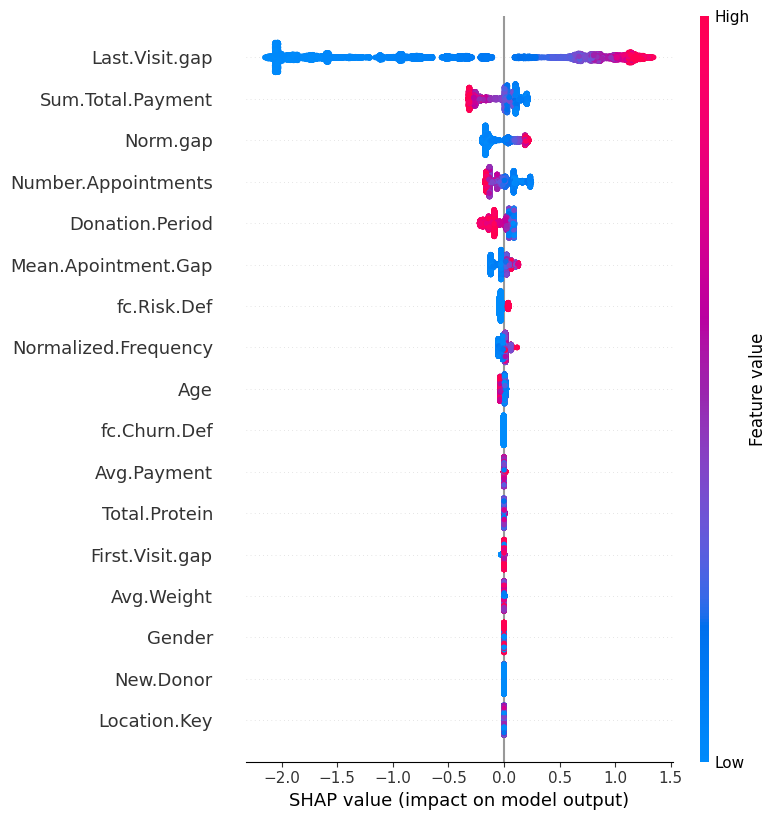

In [ ]:
shap.summary_plot(shap_values, df_shap)